# 12/29/22 - Changing the KCWI PSF routine to be used with Anowar's RXJ1131 data.

# Modified from plot_kinematics_contours_position_angles_from_hst_images.ipynb


In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf

################################################################
# some needed information
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

In [2]:
# specify object directory and name

data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/' # data directory
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
file_dir = f'{data_dir}mosaics/{obj_name}/' # directory with all files of obj_name

__________________

## First look at the KCWI integrated datacube and HSTF435W image

### redefine import_center_crop to also give 5 arcsec image

In [3]:
##############################################################################

def import_center_crop (file_dir, obj_name, obj_abbr, data_source='HST', plot=True):

    '''
    This function imports a file from the object directory, crops the image to 2 arcsec, and returns both images. 

    Inputs:
        file_dir - contains the directory containing the object's image files
        obj_name - SDSS name, e.g. SDSSJ0037-094
        obj_abbr - SDSS name, e.g. SDSSJ0037-0942 abbreviated to J0037
        data_source - which image is used, by default HST; if kcwi_datacube, use image integrated over the spectrom so it's a 2D image instead of the cube
        plot - Return both images in line

    Returns:
        _img - file image with arcsec axes, in counts
        _5arc_img
        _3arc_img = image cropped to 3 arcsecond radius, in counts
        header = input fits file header, in counts
    '''

     ##############################################################################
    # kcwi datacube

    if data_source == 'kcwi_datacube':

        file = file_dir + f"KCWI_{obj_abbr}_icubes_mosaic_0.1457_2Dintegrated.fits"
        hdu = fits.open(file)
        kcwi_img = hdu[0].data
        header = hdu[0].header
        
        # pixel scale
        kcwi_scale = 0.1457  # arcsec/pixel r_eff_V
        img_half_extent = kcwi_img.shape[0]/2 * kcwi_scale
        
        # crop the image to ~ 5 arcsec radius
        kcwi_5arc_img, central_pix_x, central_pix_y = crop_center_image(kcwi_img, 5, kcwi_scale, 'argmax')

        # crop the image to ~ 3 arcsec radius
        kcwi_3arc_img, central_pix_x, central_pix_y = crop_center_image(kcwi_img, 3, kcwi_scale, 'argmax')
        
        if plot == True:
            # plot full image
            plt.clf()
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow(kcwi_img, origin='lower',
                       extent = [-img_half_extent,img_half_extent,-img_half_extent,img_half_extent])
            plt.title('KCWI datacube')
            # plot cropped images
            plt.subplot(132)
            plt.imshow(kcwi_5arc_img, origin='lower', extent=[-5,5,-5,5])#, extent=[0,50,0,50])
            plt.contour(kcwi_5arc_img, colors='grey', extent=[-5,5,-5,5])
            plt.title('KCWI datacube')
            plt.subplot(133)
            plt.imshow(kcwi_3arc_img, origin='lower', extent=[-3,3,-3,3])#, extent=[0,50,0,50])
            plt.contour(kcwi_3arc_img, colors='grey', extent=[-3,3,-3,3])
            plt.title('KCWI datacube')
            plt.pause(1)

        return(kcwi_img, kcwi_5arc_img, kcwi_3arc_img, header, central_pix_x, central_pix_y)

   ###################################################################################
    # HST cutout

    elif data_source == 'HST':
        
        # take the F435 file if it exists, else take the F814 (if two entries for same filter take first)
        files_F435 = glob.glob(f'{file_dir}*{obj_abbr}*435*.fits')
        files_F814 = glob.glob(f'{file_dir}*{obj_abbr}*814*.fits')
        if files_F435:
            file = files_F435[0] # take the first entry of F435
            filter_name = 'F435'
        elif files_F814:
            file = files_F814[0] # take the first entry of F814
            filter_name = 'F814'
        
        hdu = fits.open(file)
        hst_img = hdu[0].data #### HST data is in counts/second
        header = hdu[0].header
        
        # multiply by exp_time to get counts
        exp_time = header['EXPTIME']
        hst_img = hst_img * exp_time

        # pixel scale
        hst_scale = 0.050 # ACS/WFC
        img_half_extent = hst_img.shape[0]/2 * hst_scale
        
        # crop the image to 5 arcsec
        hst_5arc_img, central_pix_x, central_pix_y = crop_center_image(hst_img, 5, hst_scale, 'center')

        # crop the image to 3 arcsec
        hst_3arc_img, central_pix_x, central_pix_y = crop_center_image(hst_img, 3, hst_scale, 'center')

        if plot == True:
            # plot the image
            plt.clf()
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow(hst_img, origin='lower',
                       extent = [-img_half_extent,img_half_extent,-img_half_extent,img_half_extent]) 
            plt.title(f'HST {filter_name}')
            # plot cropped image   
            plt.subplot(132)
            plt.imshow(hst_5arc_img, origin='lower', extent=[-5,5,-5,5])
            plt.contour(hst_5arc_img, colors='k', extent=[-5,5,-5,5])
            plt.title(f'HST {filter_name}')
            plt.subplot(133)
            plt.imshow(hst_3arc_img, origin='lower', extent=[-3,3,-3,3])
            plt.contour(hst_3arc_img, colors='k', extent=[-3,3,-3,3])
            plt.title(f'HST {filter_name}')
            plt.pause(1)

        return(hst_img, hst_5arc_img, hst_3arc_img, header, central_pix_x, central_pix_y)


<Figure size 432x288 with 0 Axes>

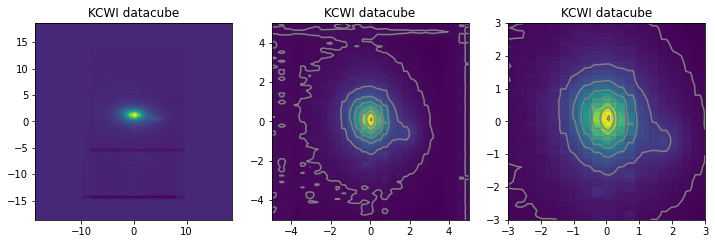

<Figure size 432x288 with 0 Axes>

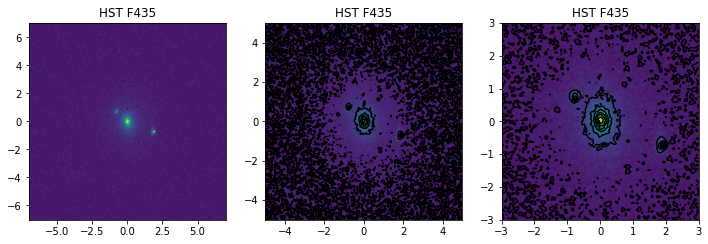

In [4]:
# import image, center, and crop

#######################################################################################
# kcwi datacube

kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                          data_source='kcwi_datacube', plot=True)

#######################################################################################
# hst cutout

hst_img, hst_5arc_img, hst_3arc_img, hst_header, \
    central_pix_x, central_pix_y = import_center_crop(hst_dir, obj_name, obj_abbr, 
                                                      data_source='HST', plot=True)


_______________________________

# PSF Estimates

## Estimate KCWI PSF

In [5]:
def fit_kcwi_sigma_psf (x, hst_img=None, kcwi_img=None, hst_scale=0.05, kcwi_scale=0.1457, plot=False):
    '''
    Fits the KCWI image with a convolution of the HST image and a Gaussian PSF with given sigma.
    Inputs:
        x is the guess and consists of:
            sigma_psf - float, sigma of Gaussian PSF, arcsec, fitting parameter for optimization 
            offset_x - int, offset allows for recentering to find the best value of sigma_psf, fitting parameter for optimization 
            offset_y - int, fitting parameter for optimization 
        hst_img - array (size n), 3 arcsec HST image
        kcwi_img - array (size m), 3 arcsec KCWI image
        hst_scale - float, pixel scale of HST image, default 0.05 "/pix
        kcwi_scale - float, pixel scale of KCWI image, default 0.1457 "/pix
    Outputs:
        residual - array (size m), subtraction of kcwi_img from convolved hst model
                    We will optimize with least squares
    '''
    
    sigma_psf = x[0]
    offset_x = x[1]
    offset_y = x[2]
    
    # make gaussian kernel with sigma_psf
    
    gaussian_2D_kernel = Gaussian2DKernel(sigma_psf/hst_scale) # convolve with HST image pixels
    if plot == True:
        # show the kernel
        plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
        plt.xlabel('x [pixels]')
        plt.ylabel('y [pixels]')
        plt.colorbar()
        plt.show()
        plt.clf()
        
    # convolve the hst image and the psf kernel
    convolved_img = convolve(hst_img, gaussian_2D_kernel)

    if plot == True:
        # show the images and the convolved image
        plt.imshow(hst_img, origin='lower')
        plt.title('HST')
        plt.pause(1)
        plt.clf()

        plt.imshow(convolved_img, origin='lower')
        plt.title('HST convolved')
        plt.pause(1)
        plt.clf()

        plt.imshow(kcwi_img, origin='lower')
        plt.title('KCWI')
        plt.pause(1)

    # make grid with kcwi_img shape times 3... and multiply by ratio of kcwi_scale/hst_scale, divide by 3
    x = np.arange(3*kcwi_img.shape[0])*kcwi_scale/hst_scale/3 - offset_x# add offset values to adjust centering
    y = np.arange(3*kcwi_img.shape[1])*kcwi_scale/hst_scale/3 - offset_y
    # make grid
    yv, xv = np.meshgrid(x, y)

    # map the convolved image to the new grid
    mapped_img = map_coordinates(convolved_img, np.array([xv, yv]), mode='nearest')

    # create new array of shape kcwi_img and sum 3x3 sections of the mapped image
    int_mapped_img = np.sum(mapped_img.reshape(kcwi_img.shape[0], 3, kcwi_img.shape[1], 3), axis=(1,3))

    if plot == True:
        plt.imshow(int_mapped_img, origin='lower')
        plt.title('Integrated mapped image')
        plt.pause(1)
        plt.clf()
        #plt.imshow(int_conv_img, origin='lower')
        #plt.title('Integrated image without mapping')
        #plt.pause(1)
        #plt.clf()
        #plt.imshow(diff, origin='lower')
        #plt.title('Residual between two integrated images')
        #plt.pause(1)
        #plt.clf()
        
    # normalize the images
    # integrated mapped image
    int_mapped_img_norm = int_mapped_img / np.sum(int_mapped_img)
    # kcwi image
    kcwi_img_norm = kcwi_img / np.sum(kcwi_img)

    # take residual of normed images
    residual = int_mapped_img_norm - kcwi_img_norm
    
    plt.imshow(residual, origin='lower')
    if plot==True:
        plt.colorbar()
    plt.title('Residual')

    # return the residual flattened
    return residual.ravel()


In [6]:

########################################################################################

def optimize_sigma_psf_fit (fit_kcwi_sigma_psf, sigma_psf_guess=0.5, offset_x_guess=0., offset_y_guess=0., # use offset 
                            hst_img=None, kcwi_img=None, hst_scale=0.050, kcwi_scale=0.1457, plot=True):
    '''
    Function to optimize with least squares optimization the fit of KCWI sigma_psf by convolving the HST img
    with Gaussian PSF.
    Inputs:
        - fit_kcwi_sigma_psf - function that fits the KCWI image with HST image convolved with a sigma_psf
        - sigma_psf_guess - float, first guess at the sigma_psf value, pixels
        - hst_img 
        - kcwi_img
    '''
    
    x0 = np.array([sigma_psf_guess, offset_x_guess, offset_y_guess], dtype=float)
    
    # optimize the function
    result = lsq(fit_kcwi_sigma_psf, x0=x0, kwargs={'hst_img':hst_img,'kcwi_img':kcwi_img,
                                                                 'plot':False})
    print(result.x.shape)
    # state the best-fit sigma-psf and loss function value
    best_fit_psf = result.x[0]
    offset_x = result.x[1]
    offset_y = result.x[2]
    loss = result.cost
    print(result.status)
    print(f'Best fit sigma-PSF is {best_fit_psf} arcsec')
    print(f'Best fit loss function value is {loss}')
    print(f'Offsets: {offset_x},{offset_y}')
    
    # take best_residual
    best_residual = result.fun.reshape(kcwi_img.shape)
    print(np.sum(abs(best_residual)))
    
    # show residual
    if plot == True:
        plt.imshow(best_residual, origin='lower')
        plt.colorbar()
        plt.title('Best fit residual')
        
    return best_fit_psf, loss, best_residual
    

In [7]:
hst_img = hst_3arc_img/np.sum(hst_3arc_img)
kcwi_img = kcwi_3arc_img/np.sum(kcwi_3arc_img)

(3,)
1
Best fit sigma-PSF is 0.33157986291412844 arcsec
Best fit loss function value is 3.137337436486737e-05
Offsets: 0.6141662127260541,2.245369980496255
0.23854646929550627


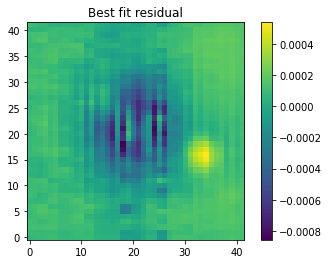

In [8]:
kcwi_sigmapsf, loss, residual = optimize_sigma_psf_fit (fit_kcwi_sigma_psf, sigma_psf_guess=0.35, hst_img=hst_img, kcwi_img=kcwi_img)

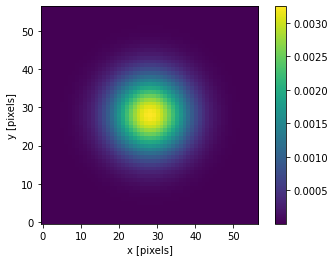

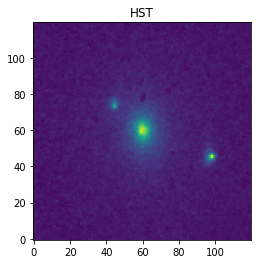

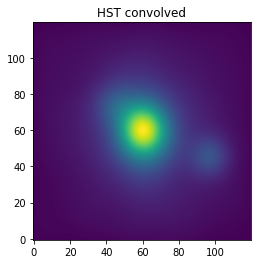

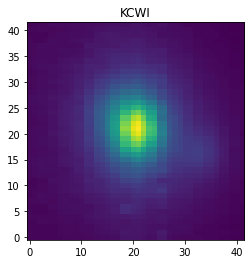

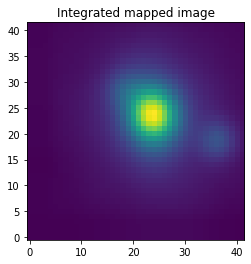

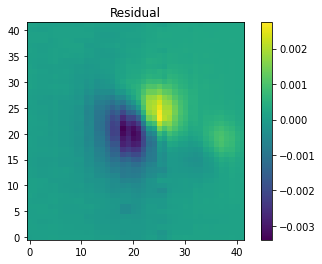

In [25]:
# checking to make sure the offset works properly
x = [0.35,10.,10.]
residual = fit_kcwi_sigma_psf (x, hst_img=hst_img, kcwi_img=kcwi_img, hst_scale=0.05, kcwi_scale=0.1457, plot=True)

# Bring in RXJ1131 data from Anowar. HST image is fits file, KCWI is a txt file.

In [26]:
hst_file = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tdcosmo_lenses/RXJ1131/RXJ1131_F814W_cutout_sci.fits' 
kcwi_file = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tdcosmo_lenses/RXJ1131/KCWI_data.txt'

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  160                                                  NAXIS2  =                  160                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

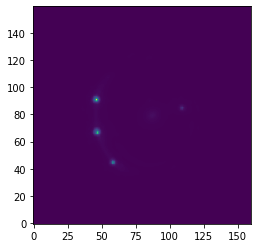

In [27]:
# hst file
hdul = fits.open(hst_file)
hdul.verify('fix')
hst_data = hdul[0].data
hst_header = hdul[0].header
print(hst_header)
print(hst_data.shape)
plt.imshow(hst_data, origin='lower')


In [28]:
def crop_center_image (img, radius, scale, method='center'):
    
    '''
    Takes image, crops at argmax, and returns a 2radius x 2radius square image centered at the lower left corner of the center pixel
    
    img - (n,n) image with nxn pixels
    
    radius - radius in arcsec to which the 
    
    scale - pixel scale (arcsec/pix)
    
    method - str, default 'center' does not recenter, 'argmax' recenters to maximum pixel argument
    '''
    
    # take center pixel
    if method == 'center':
        # take center of input image
        central_pix_x = int(np.floor(img.shape[0]/2))
        central_pix_y = int(np.floor(img.shape[1]/2))
    elif method == 'argmax':
        # take center of image at argmax 
        central_pix = np.unravel_index(np.argmax(img, axis=None), img.shape)
        central_pix_x = central_pix[1]
        central_pix_y = central_pix[0]   
    
    # take radius in pixels
    radius = int(np.around(radius / scale))
    
    # crop to radius
    cropped_img = img[central_pix_y - radius:central_pix_y + radius, central_pix_x - radius:central_pix_x + radius]
    
    return(cropped_img, central_pix_x, central_pix_y)

In [29]:
# crop the image to 5 arcsec
hst_3arc_img, central_pix_x, central_pix_y = crop_center_image(hst_data, 3, hst_scale, 'center')

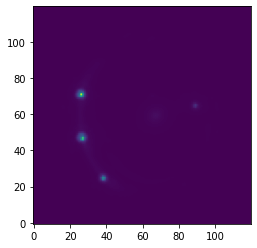

In [30]:
plt.imshow(hst_3arc_img, origin='lower')

In [31]:
hst_3arc_img.shape

(120, 120)

In [32]:
# max pixel should be the brightest quasar point
A_y_hst, A_x_hst = np.unravel_index(np.argmax(hst_3arc_img), hst_3arc_img.shape)

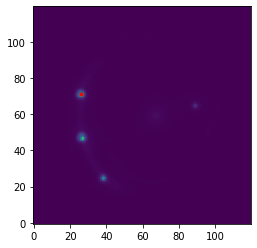

In [33]:
plt.imshow(hst_3arc_img, origin='lower')
plt.scatter(A_x_hst, A_y_hst, marker='.', color='r')

In [34]:
# kcwi file
kcwi_data = np.genfromtxt(kcwi_file)
print(kcwi_data.shape)

(43, 43)


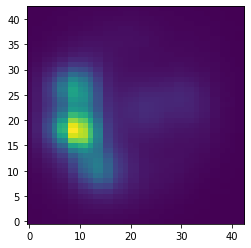

In [35]:
kcwi_3arc_img = kcwi_data
plt.imshow(kcwi_3arc_img, origin='lower')

In [36]:
# max pixel should be the brightest quasar point
A_y_kcwi, A_x_kcwi = np.unravel_index(np.argmax(kcwi_3arc_img), kcwi_3arc_img.shape)

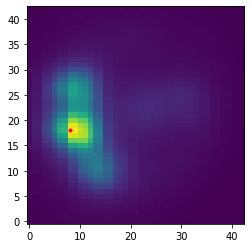

In [37]:
plt.imshow(kcwi_3arc_img, origin='lower')
plt.scatter(A_x_kcwi, A_y_kcwi, marker='.', color='r')

# Estimate the KCWI PSF

(3,)
2
Best fit sigma-PSF is 0.40045993275821046 arcsec
Best fit loss function value is 0.0002123179906947261
Offsets: 0.31572050256995327,-0.03643113388730704
0.46668776543921964


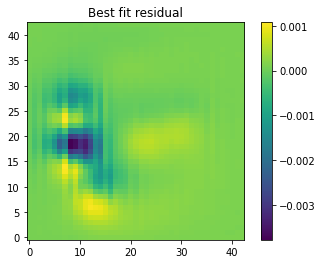

In [38]:
kcwi_sigmapsf, loss, residual = optimize_sigma_psf_fit (fit_kcwi_sigma_psf, hst_img=hst_3arc_img, kcwi_img=kcwi_3arc_img)

# It looks like it isn't handling the offset properly... Need to initialize closer

(3,)
3
Best fit sigma-PSF is 0.35402513198233443 arcsec
Best fit loss function value is 0.00016750331464533027
Offsets: -0.23478011804824378,8.450198169116675
0.4196884221591031


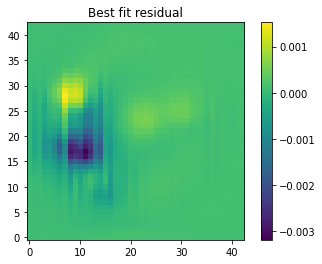

In [39]:
kcwi_sigmapsf, loss, residual = optimize_sigma_psf_fit (fit_kcwi_sigma_psf, offset_x_guess=0., offset_y_guess=20, hst_img=hst_3arc_img, kcwi_img=kcwi_3arc_img)

# What does it look like when the HST image is convolved with this psf?

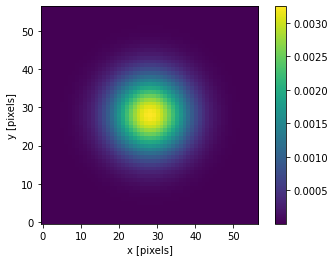

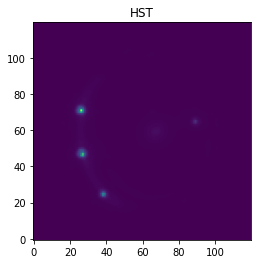

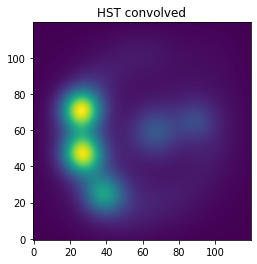

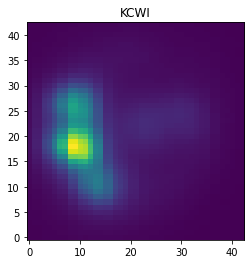

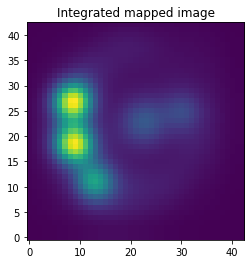

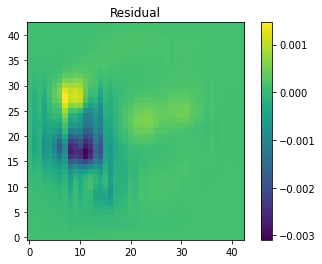

In [45]:
x = [0.35,-0.2,8]
residual = fit_kcwi_sigma_psf (x, hst_img=hst_3arc_img, kcwi_img=kcwi_3arc_img, hst_scale=0.05, kcwi_scale=0.1457, plot=True)